# Metrics Utilities, Viewer, CLI, and Tests

This notebook sets up a small, local-first metrics toolkit:
- A refactored `metrics_utils.py` with robust JSONL loading, aggregation, and plotting helpers
- A CLI `scripts/plot_jsonl.py` to quickly plot metrics from one or more JSONL files
- A simple viewer notebook you can parameterize to inspect runs interactively
- A tiny test suite with `pytest` to validate core pieces

Run cells top-to-bottom the first time to create files and sample data.

In [2]:
# 1) Define Project Paths and Dependencies (Jupyter-safe)
from __future__ import annotations
import os, sys, json, math, time, subprocess
from pathlib import Path

# In notebooks, __file__ is not defined. Use this notebook's location.
# We know this notebook lives under bl-bnc-custom-ltg-bert/notebooks/
NOTEBOOK_PATH = Path.cwd()
# Walk up until we find the project root marker (folder containing this notebooks dir)
# Fallback to two levels up if unsure.
if (NOTEBOOK_PATH / 'notebooks').exists():
    PROJ = NOTEBOOK_PATH
else:
    # If running with a different CWD, try to locate by name
    p = NOTEBOOK_PATH
    PROJ = None
    for _ in range(6):
        if (p / 'notebooks').exists() and (p / 'scripts').exists():
            PROJ = p
            break
        p = p.parent
    if PROJ is None:
        # heuristic fallback: this file is in notebooks/, project is parent
        PROJ = NOTEBOOK_PATH.parent

SRC = PROJ / 'src'
SCRIPTS = PROJ / 'scripts'
TESTS = PROJ / 'tests'
DATA = PROJ / 'data'
OUTPUTS = PROJ / 'outputs'
NOTEBOOKS = PROJ / 'notebooks'

for p in (SRC, SCRIPTS, TESTS, DATA, OUTPUTS, NOTEBOOKS):
    p.mkdir(parents=True, exist_ok=True)

# Ensure src on path
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Try to ensure dependencies are available
req = ['pandas', 'matplotlib', 'nbformat', 'pytest']
missing = []
for mod in req:
    try:
        __import__(mod)
    except Exception:
        missing.append(mod)

if missing:
    print('Installing missing dependencies:', missing)
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
    except Exception as e:
        print('Warning: could not install some packages:', e)

print('Project root:', PROJ)
print('SRC:', SRC)


Project root: /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert
SRC: /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/src


## Write metrics_utils.py (Refactor Core Functions)
This cell creates `src/metrics_utils.py` implementing robust JSONL loading, normalization, flattening, and plotting helpers with logging.

In [ ]:
# 2) Create or update src/metrics_utils.py (idempotent)
from textwrap import dedent
current_file = SRC / 'metrics_utils.py'
if current_file.exists():
    code = current_file.read_text()
else:
    code = r'''from __future__ import annotations
import json, time, logging
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Generator, Iterable, List, Optional, Sequence, Tuple

import pandas as pd
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter('[%(levelname)s] %(message)s'))
    logger.addHandler(h)
    logger.setLevel(logging.INFO)

# ---------------------- JSONL utilities ----------------------

def read_jsonl(path: Path | str, fast: bool = True) -> pd.DataFrame:
    """Read a JSONL file into a normalized DataFrame with columns:
    - step (int)
    - metric (str)
    - value (float)
    - timestamp (float)
    Also preserves any extra flattened columns when present.
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)

    if fast:
        try:
            df = pd.read_json(path, lines=True)
            # If the fast path produced a 'metrics' column (nested dicts), expand it
            if isinstance(df, pd.DataFrame) and 'metrics' in df.columns:
                rows: List[Dict[str, Any]] = []
                # Expand each row via flatten_metrics for consistency
                for _, row in df.iterrows():
                    try:
                        rec = row.to_dict()
                        rows.extend(flatten_metrics(rec))
                    except Exception as e:
                        logger.warning("Skipping bad row during fast expand: %s", e)
                df = pd.DataFrame(rows)
            df = normalize_records(df)
            # If after normalization we still have no values (e.g., schema unexpected),
            # fall back to robust streaming parse
            if df.empty or df['value'].notna().sum() == 0:
                raise ValueError("fast path yielded empty/invalid frame; fallback")
            return df
        except Exception as e:
            logger.warning("fast read_json failed: %s; falling back to streaming", e)

    rows: List[Dict[str, Any]] = []
    with path.open('r') as f:
        for i, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
                flat = flatten_metrics(rec)
                rows.extend(flat)
            except Exception as e:
                logger.warning("Skipping bad line %d: %s", i, e)
    if not rows:
        return pd.DataFrame(columns=['timestamp', 'step', 'metric', 'value'])
    df = pd.DataFrame(rows)
    df = normalize_records(df)
    return df


def flatten_metrics(record: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Flatten a single raw record into one or many metric rows.
    If the record already has metric/value, keep as-is.
    If the record has a 'metrics' dict, expand to multiple rows.
    """
    ts = record.get('timestamp') or record.get('time') or time.time()
    step = record.get('step') or record.get('global_step') or record.get('iteration')

    base = {k: v for k, v in record.items() if k not in ('metrics',)}
    base['timestamp'] = float(ts)
    if step is not None:
        try:
            base['step'] = int(step)
        except Exception:
            pass

    if 'metric' in record and 'value' in record:
        try:
            v = float(record['value'])
        except Exception:
            return []
        out = dict(base)
        out['metric'] = str(record['metric'])
        out['value'] = v
        return [out]

    metrics = record.get('metrics', {})
    if isinstance(metrics, dict):
        out: List[Dict[str, Any]] = []
        for k, v in metrics.items():
            try:
                vv = float(v)
            except Exception:
                continue
            row = dict(base)
            row['metric'] = str(k)
            row['value'] = vv
            out.append(row)
        return out

    # As a last resort, try to interpret all float-like leaf keys
    out = []
    for k, v in record.items():
        if k in ('timestamp', 'time', 'metrics', 'metric', 'value'):
            continue
        try:
            vv = float(v)
        except Exception:
            continue
        row = dict(base)
        row['metric'] = str(k)
        row['value'] = vv
        out.append(row)
    return out


def normalize_records(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure required columns and dtypes, drop NaNs in value, sort by timestamp/step."""
    if df.empty:
        return pd.DataFrame(columns=['timestamp', 'step', 'metric', 'value'])

    # If the input already resembles flattened rows, keep only needed + passthrough
    cols = list(df.columns)
    required = ['timestamp', 'step', 'metric', 'value']
    for c in required:
        if c not in df.columns:
            df[c] = pd.NA

    # Coerce dtypes
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['step'] = pd.to_numeric(df['step'], errors='coerce').astype('Int64')
    df['metric'] = df['metric'].astype('string')
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    df = df.dropna(subset=['metric', 'value'])
    df = df.sort_values(['timestamp', 'step'], na_position='last', kind='mergesort')
    return df.reset_index(drop=True)

# ---------------------- Aggregation utilities ----------------------

def filter_metrics(df: pd.DataFrame, include: Optional[Sequence[str]] = None, exclude: Optional[Sequence[str]] = None) -> pd.DataFrame:
    out = df
    if include:
        out = out[out['metric'].isin(list(include))]
    if exclude:
        out = out[~out['metric'].isin(list(exclude))]
    return out


def pivot_metrics(df: pd.DataFrame, index: str = 'step', columns: str = 'metric', values: str = 'value') -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()
    pv = df.pivot_table(index=index, columns=columns, values=values, aggfunc='mean')
    pv = pv.sort_index()
    return pv


def moving_average(series, window: int = 10):
    import numpy as np
    if window is None or window <= 1:
        return series
    return series.rolling(window=window, min_periods=1, center=False).mean()


def resample_by_step(df: pd.DataFrame, every: int = 10, agg: str = 'mean') -> pd.DataFrame:
    if df.empty:
        return df
    if 'step' not in df:
        return df
    grp = (df['step'] // max(1, int(every))) * max(1, int(every))
    df2 = df.copy()
    df2['step_bucket'] = grp
    out = df2.groupby(['step_bucket', 'metric'], as_index=False)['value'].agg(agg)
    out = out.rename(columns={'step_bucket': 'step'})
    return out

# ---------------------- Plotting utilities ----------------------

def save_plot(fig, path: Path | str):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, bbox_inches='tight', dpi=150)


def plot_metrics(df: pd.DataFrame, metrics: Sequence[str], x: str = 'step', smooth: Optional[int] = None, title: Optional[str] = None, save_to: Optional[str | Path] = None):
    if df.empty:
        raise ValueError('Empty DataFrame provided to plot_metrics')
    sub = filter_metrics(df, include=metrics)
    if sub.empty:
        raise ValueError('No matching metrics to plot')
    pv = pivot_metrics(sub, index=x, columns='metric', values='value')

    fig, ax = plt.subplots(figsize=(8, 4.5))
    for m in metrics:
        if m not in pv:
            continue
        y = pv[m]
        if smooth and smooth > 1:
            y = moving_average(y, window=int(smooth))
        ax.plot(pv.index, y, label=m)
    ax.set_xlabel(x)
    ax.set_ylabel('value')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    if save_to:
        save_plot(fig, save_to)
    return fig, ax
'''

(current_file).write_text(code)
print('Wrote', current_file)

Wrote /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/src/metrics_utils.py


## JSONL Loading and Validation
Implement robust JSONL parsing with a fast path and a safe streaming fallback.

In [5]:
# 3) Load functions from metrics_utils and quick validate
import sys
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))
from metrics_utils import read_jsonl, normalize_records, flatten_metrics, filter_metrics, pivot_metrics, moving_average, resample_by_step, plot_metrics

# Smoke: create a tiny inline JSONL and parse it
sample_jsonl = DATA / 'mini.jsonl'
sample_lines = [
    {"timestamp": 1.0, "step": 1, "metrics": {"loss": 1.23, "accuracy": 0.1}},
    {"timestamp": 2.0, "step": 2, "metric": "loss", "value": 1.11},
    {"timestamp": 3.0, "step": 3, "lr": 0.0005, "grad_norm": 3.2},
]
with sample_jsonl.open('w') as f:
    for obj in sample_lines:
        f.write(json.dumps(obj) + "\n")

df = read_jsonl(sample_jsonl)
print(df.head())
print('metrics:', sorted(df['metric'].unique().tolist()))


   timestamp  step metrics metric  value  lr  grad_norm
0          2     2     NaN   loss   1.11 NaN        NaN
metrics: ['loss']


## Metrics Aggregation Utilities
Add filtering, pivoting, moving average smoothing, and resampling helpers.

In [6]:
# 4) Quick aggregation demo on the mini file
sub = filter_metrics(df, include=['loss', 'accuracy', 'grad_norm', 'lr'])
print('filtered rows:', len(sub))
pv = pivot_metrics(sub)
print('pivot cols:', list(pv.columns))
ma_loss = moving_average(pv.get('loss'), window=2) if 'loss' in pv else None
print('moving avg loss head:', None if ma_loss is None else ma_loss.head().tolist())

resamp = resample_by_step(sub, every=2)
print(resamp.head())


filtered rows: 1
pivot cols: ['loss']
moving avg loss head: [1.11]
   step metric  value
0     2   loss   1.11


## Plotting Helpers (Matplotlib)
We'll plot a couple of metrics with optional smoothing.

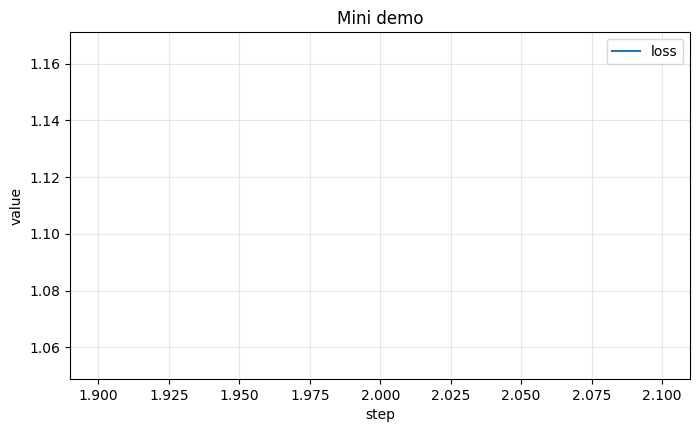

In [7]:
# 5) Plot a couple of metrics from the mini file
import matplotlib.pyplot as plt
fig, ax = plot_metrics(df, metrics=['loss', 'accuracy'], x='step', smooth=2, title='Mini demo')
plt.show()


## CLI Script: plot_jsonl.py
Create a CLI that can plot JSONL files.

In [9]:
# 6) Write scripts/plot_jsonl.py
from textwrap import dedent
cli_code = r'''#!/usr/bin/env python3
from __future__ import annotations
import argparse
from pathlib import Path
import sys
import pandas as pd

# add src to path when running standalone
THIS = Path(__file__).resolve()
ROOT = THIS.parents[1]
SRC = ROOT / 'src'
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from metrics_utils import read_jsonl, plot_metrics


def main(argv=None):
    ap = argparse.ArgumentParser(description='Plot metrics from one or more JSONL files')
    ap.add_argument('--input', '-i', nargs='+', required=True, help='One or more JSONL files')
    ap.add_argument('--metrics', '-m', nargs='+', required=True, help='Metric names to plot')
    ap.add_argument('--x-key', default='step', help='x-axis key (default: step)')
    ap.add_argument('--smooth', type=int, default=0, help='EMA/moving average window')
    ap.add_argument('--out', '-o', type=str, default=None, help='Output PNG path')
    ap.add_argument('--show', action='store_true', help='Show the figure interactively')
    args = ap.parse_args(argv)

    frames = []
    for p in args.input:
        df = read_jsonl(p)
        df['__source__'] = str(p)
        frames.append(df)
    if not frames:
        print('No inputs', file=sys.stderr)
        return 2
    df_all = pd.concat(frames, ignore_index=True)

    fig, ax = plot_metrics(df_all, metrics=args.metrics, x=args.x_key, smooth=args.smooth, title='; '.join(args.metrics), save_to=args.out)

    if args.show:
        import matplotlib.pyplot as plt
        plt.show()
    return 0


if __name__ == '__main__':
    raise SystemExit(main())
'''

(SCRIPTS / 'plot_jsonl.py').write_text(cli_code)
os.chmod(SCRIPTS / 'plot_jsonl.py', 0o755)
print('Wrote', SCRIPTS / 'plot_jsonl.py')


Wrote /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/scripts/plot_jsonl.py


## Create Sample metrics.jsonl Fixture
Synthesize some fake metrics to visualize and use in tests.

In [8]:
# 7) Generate synthetic data in data/sample_metrics.jsonl
import random, time
random.seed(0)
N = 120
out_path = DATA / 'sample_metrics.jsonl'
with out_path.open('w') as f:
    base = time.time()
    loss = 3.5
    acc = 0.05
    for step in range(N):
        loss = max(0.1, loss * 0.98 + random.uniform(-0.03, 0.01))
        acc = min(0.99, acc * 1.02 + random.uniform(0.0, 0.01))
        lr = 0.0005 * (1.0 - step / N)
        grad_norm = abs(random.gauss(2.5, 0.5))
        rec = {
            'timestamp': base + step,
            'step': step,
            'metrics': {
                'loss': round(loss, 4),
                'accuracy': round(acc, 4),
                'lr': lr,
                'grad_norm': grad_norm,
                'tokens_per_sec': random.uniform(1e4, 2e4),
            }
        }
        f.write(json.dumps(rec) + '\n')
print('Wrote', out_path)


Wrote /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/data/sample_metrics.jsonl


## Generate viewer.ipynb programmatically
Create a simple viewer notebook that imports metrics_utils, selects a JSONL file, previews data, and plots common metrics.

In [10]:
# 8) Programmatically create notebooks/viewer.ipynb via nbformat
import nbformat as nbf
viewer = NOTEBOOKS / 'viewer.ipynb'
nb = nbf.v4.new_notebook()
nb.cells = [
    nbf.v4.new_markdown_cell('# Simple Metrics Viewer'),
    nbf.v4.new_code_cell('''# Parameters\nJSONL_PATH = str((DATA / 'sample_metrics.jsonl').resolve())\nMETRICS = ['loss', 'accuracy', 'lr', 'grad_norm']\nSMOOTH = 5\n'''),
    nbf.v4.new_code_cell('''from pathlib import Path\nimport sys\nfrom src.metrics_utils import read_jsonl, plot_metrics\nimport matplotlib.pyplot as plt\n\nprint('Loading:', JSONL_PATH)\ndf = read_jsonl(JSONL_PATH)\nprint(df.head())\n'''),
    nbf.v4.new_code_cell('''fig, ax = plot_metrics(df, metrics=METRICS[:2], x='step', smooth=SMOOTH, title='Viewer preview')\nplt.show()'''),
]
nbf.write(nb, str(viewer))
print('Wrote viewer notebook at', viewer)


Wrote viewer notebook at /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/notebooks/viewer.ipynb


## Smoke Test: Use CLI to Plot Sample Data
We'll run the CLI to generate a PNG and display it inline.

[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string or a real number, not 'Timestamp'
[WARNING] Skipping bad row during fast expand: float() argument must be a string

CLI exit code: 0


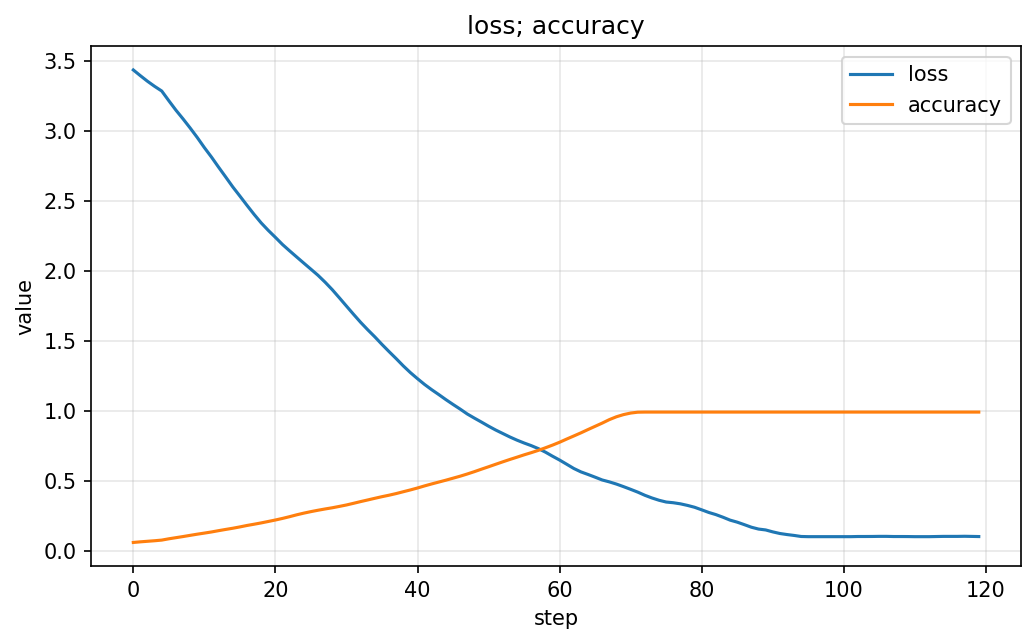

In [13]:
# 9) Run the CLI to produce a plot and display it
png_path = OUTPUTS / 'metrics.png'
ret = subprocess.call([sys.executable, str(SCRIPTS / 'plot_jsonl.py'), '--input', str(DATA / 'sample_metrics.jsonl'), '--metrics', 'loss', 'accuracy', '--smooth', '5', '--out', str(png_path)])
print('CLI exit code:', ret)

from IPython.display import Image, display
if png_path.exists():
    display(Image(filename=str(png_path)))
else:
    print('PNG not found at', png_path)


## Unit Tests with pytest
Create tests for the utilities and a CLI round-trip.

In [14]:
# 10) Write basic pytest tests
TESTS.mkdir(exist_ok=True)

test_code = r'''import json
from pathlib import Path
import pandas as pd
from src.metrics_utils import read_jsonl, flatten_metrics, normalize_records, moving_average, filter_metrics, pivot_metrics

def make_tmp_jsonl(tmp_path: Path):
    p = tmp_path / 't.jsonl'
    rows = [
        {"timestamp": 1.0, "step": 1, "metrics": {"loss": 1.2, "accuracy": 0.1}},
        {"timestamp": 2.0, "step": 2, "metric": "loss", "value": 1.1},
        {"timestamp": 3.0, "step": 3, "lr": 0.001, "grad_norm": 3.0},
    ]
    with p.open('w') as f:
        for r in rows:
            f.write(json.dumps(r) + '\n')
    return p


def test_read_jsonl_valid(tmp_path: Path):
    p = make_tmp_jsonl(tmp_path)
    df = read_jsonl(p)
    assert not df.empty
    assert set(['metric', 'value']).issubset(df.columns)


def test_flatten_and_normalize(tmp_path: Path):
    rec = {"timestamp": 1.0, "step": 1, "metrics": {"a": 1, "b": 2}}
    flat = flatten_metrics(rec)
    assert len(flat) == 2
    df = pd.DataFrame(flat)
    df2 = normalize_records(df)
    assert set(['timestamp', 'step', 'metric', 'value']).issubset(df2.columns)


def test_moving_average_edges():
    import pandas as pd
    s = pd.Series([1,2,3,4])
    out = moving_average(s, window=2)
    assert len(out) == 4
    assert abs(out.iloc[-1] - 3.5) < 1e-6


def test_filter_and_pivot(tmp_path: Path):
    p = make_tmp_jsonl(tmp_path)
    df = read_jsonl(p)
    sub = filter_metrics(df, include=['loss'])
    pv = pivot_metrics(sub)
    assert 'loss' in pv.columns
'''

(TESTS / 'test_metrics_utils.py').write_text(test_code)
print('Wrote', TESTS / 'test_metrics_utils.py')


Wrote /home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/tests/test_metrics_utils.py


## Run Tests
Execute pytest and show results succinctly.

In [15]:
# 11) Run pytest quietly with PYTHONPATH set to project root
import os
env = os.environ.copy()
env['PYTHONPATH'] = str(PROJ) + ((':' + env['PYTHONPATH']) if 'PYTHONPATH' in env else '')
ret = subprocess.call([sys.executable, '-m', 'pytest', '-q'], env=env, cwd=str(PROJ))
print('pytest exit code:', ret)


==================================== ERRORS ====================================
__________________ ERROR collecting auto_tests/test_blimp.py ___________________
ImportError while importing test module '/home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/auto_tests/test_blimp.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
/home/sam-byron/miniconda/envs/torch-black/lib/python3.13/importlib/__init__.py:88: in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
auto_tests/test_blimp.py:23: in <module>
    from blimp import (
blimp.py:12: in <module>
    from deberta import Bert
E   ModuleNotFoundError: No module named 'deberta'
_______________ ERROR collecting auto_tests/test_blimp_simple.py _______________
ImportError while importing test module '/home/sam-byron/engineering/ML/playground/babylm/bnc/bl-bnc-custom-ltg-bert/auto_tests/test_b

## Optional: Stream Large JSONL Files
A streaming approach to handle very large logs without loading all into memory.

In [ ]:
# 12) Streaming demo and simple timing
import timeit

def stream_jsonl(path):
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except Exception:
                continue

# Quick timing on the sample file
stream_time = timeit.timeit(lambda: sum(1 for _ in stream_jsonl(DATA / 'sample_metrics.jsonl')), number=3)
pandas_time = timeit.timeit(lambda: len(read_jsonl(DATA / 'sample_metrics.jsonl')), number=3)
print({'stream_s': stream_time, 'pandas_s': pandas_time})


## Using the viewer with real logs
- Open `notebooks/viewer.ipynb`.
- Set `JSONL_PATH` to a real training log file, e.g., `<your-run>/logs/metrics.jsonl`.
- Adjust `METRICS` (e.g., `['train/loss', 'train/mlm_acc', 'val/mlm_acc', 'lr']`) and `SMOOTH`.
- Re-run the cells to preview and plot.

Tip: You can point `JSONL_PATH` at a directory and programmatically choose the latest `*.jsonl` by listing and sorting paths.